## MNist Neural Network

The goal is to achieve 99.4% validation/test accuracy, with less than 20k Parameters and in 20 epochs | changed model architecture 15k parameters, moved 1x1 before Max Pool

### Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt

### Model Architecture

In [2]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3) #3
        self.conv2 = nn.Conv2d(8, 10, kernel_size=3) #5
        self.conv3 = nn.Conv2d(10, 16, kernel_size=3) #7
        self.conv4 = nn.Conv2d(16, 8, kernel_size=1)
        self.conv5 = nn.Conv2d(8, 10, kernel_size=3)
        self.conv6 = nn.Conv2d(10, 16, kernel_size=3)
        self.conv7 = nn.Conv2d(16, 28, kernel_size=3)
        self.fc1 = nn.Linear(5 * 5 * 28, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x), 2) # 26 x 26 x 16
        x = F.relu(self.conv2(x), 2) # 24 x 24 x 10
        x = F.relu(self.conv3(x), 2) # 22 x 22 x 10
        x = F.relu(F.max_pool2d(self.conv4(x), 2))  # 22 x 22 x 8 | 11 x 11 x 8
        x = F.relu(self.conv5(x), 2) # 9 x 9 x 10
        x = F.relu(self.conv6(x), 2) # 7 x 7 x 16
        x = F.relu(self.conv7(x), 2) # 5 x 5 x 28
        x = x.view(-1, 5 * 5 * 28)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

### Check if CUDA is available and display model parameters


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
            Conv2d-2           [-1, 10, 24, 24]             730
            Conv2d-3           [-1, 16, 22, 22]           1,456
            Conv2d-4            [-1, 8, 22, 22]             136
            Conv2d-5             [-1, 10, 9, 9]             730
            Conv2d-6             [-1, 16, 7, 7]           1,456
            Conv2d-7             [-1, 28, 5, 5]           4,060
            Linear-8                   [-1, 10]           7,010
Total params: 15,658
Trainable params: 15,658
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.19
Params size (MB): 0.06
Estimated Total Size (MB): 0.25
----------------------------------------------------------------


### Print model architecture

In [4]:
print(model)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
  (conv5): Conv2d(8, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(10, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(16, 28, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=700, out_features=10, bias=True)
)


### Load train and test data, and apply transformations

In [5]:
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                    transforms.Resize((28, 28)),
                    transforms.RandomRotation((-15., 15.), fill=0),
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,)),
                    ])),batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 511kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.69MB/s]


In [6]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

### Training Loop

In [7]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss = 0
    correct = 0
    processed = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(desc= f'Train loss={loss.item():0.4f} batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    train_losses.append(loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Model training

In [8]:

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 20

for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Epoch 1


Train loss=0.2319 batch_id=468 Accuracy=81.59: 100%|██████████| 469/469 [00:23<00:00, 19.86it/s]


Test set: Average loss: 0.1056, Accuracy: 9673/10000 (96.73%)

Epoch 2


Train loss=0.2411 batch_id=468 Accuracy=95.37: 100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


Test set: Average loss: 0.0660, Accuracy: 9784/10000 (97.84%)

Epoch 3


Train loss=0.1419 batch_id=468 Accuracy=96.56: 100%|██████████| 469/469 [00:23<00:00, 20.15it/s]


Test set: Average loss: 0.0583, Accuracy: 9822/10000 (98.22%)

Epoch 4


Train loss=0.1696 batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:23<00:00, 20.05it/s]


Test set: Average loss: 0.0540, Accuracy: 9810/10000 (98.10%)

Epoch 5


Train loss=0.1050 batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:23<00:00, 20.17it/s]


Test set: Average loss: 0.0399, Accuracy: 9866/10000 (98.66%)

Epoch 6


Train loss=0.1074 batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:23<00:00, 20.14it/s]


Test set: Average loss: 0.0388, Accuracy: 9886/10000 (98.86%)

Epoch 7


Train loss=0.0877 batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:23<00:00, 20.20it/s]


Test set: Average loss: 0.0385, Accuracy: 9869/10000 (98.69%)

Epoch 8


Train loss=0.0114 batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:23<00:00, 20.25it/s]


Test set: Average loss: 0.0411, Accuracy: 9862/10000 (98.62%)

Epoch 9


Train loss=0.1361 batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:22<00:00, 20.45it/s]


Test set: Average loss: 0.0303, Accuracy: 9900/10000 (99.00%)

Epoch 10


Train loss=0.0366 batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]


Test set: Average loss: 0.0274, Accuracy: 9901/10000 (99.01%)

Epoch 11


Train loss=0.0922 batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 20.52it/s]


Test set: Average loss: 0.0289, Accuracy: 9900/10000 (99.00%)

Epoch 12


Train loss=0.0987 batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:23<00:00, 20.30it/s]


Test set: Average loss: 0.0283, Accuracy: 9906/10000 (99.06%)

Epoch 13


Train loss=0.0153 batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:23<00:00, 20.16it/s]


Test set: Average loss: 0.0294, Accuracy: 9902/10000 (99.02%)

Epoch 14


Train loss=0.0590 batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:23<00:00, 20.21it/s]


Test set: Average loss: 0.0282, Accuracy: 9911/10000 (99.11%)

Epoch 15


Train loss=0.0232 batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:23<00:00, 20.24it/s]


Test set: Average loss: 0.0269, Accuracy: 9909/10000 (99.09%)

Epoch 16


Train loss=0.0046 batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:23<00:00, 20.39it/s]


Test set: Average loss: 0.0186, Accuracy: 9942/10000 (99.42%)

Epoch 17


Train loss=0.0092 batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]


Test set: Average loss: 0.0184, Accuracy: 9937/10000 (99.37%)

Epoch 18


Train loss=0.0115 batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:23<00:00, 20.33it/s]


Test set: Average loss: 0.0183, Accuracy: 9939/10000 (99.39%)

Epoch 19


Train loss=0.0385 batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:23<00:00, 20.37it/s]


Test set: Average loss: 0.0177, Accuracy: 9944/10000 (99.44%)

Epoch 20


Train loss=0.0145 batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:23<00:00, 20.32it/s]


Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)



### Plots

Text(0.5, 1.0, 'Test Accuracy')

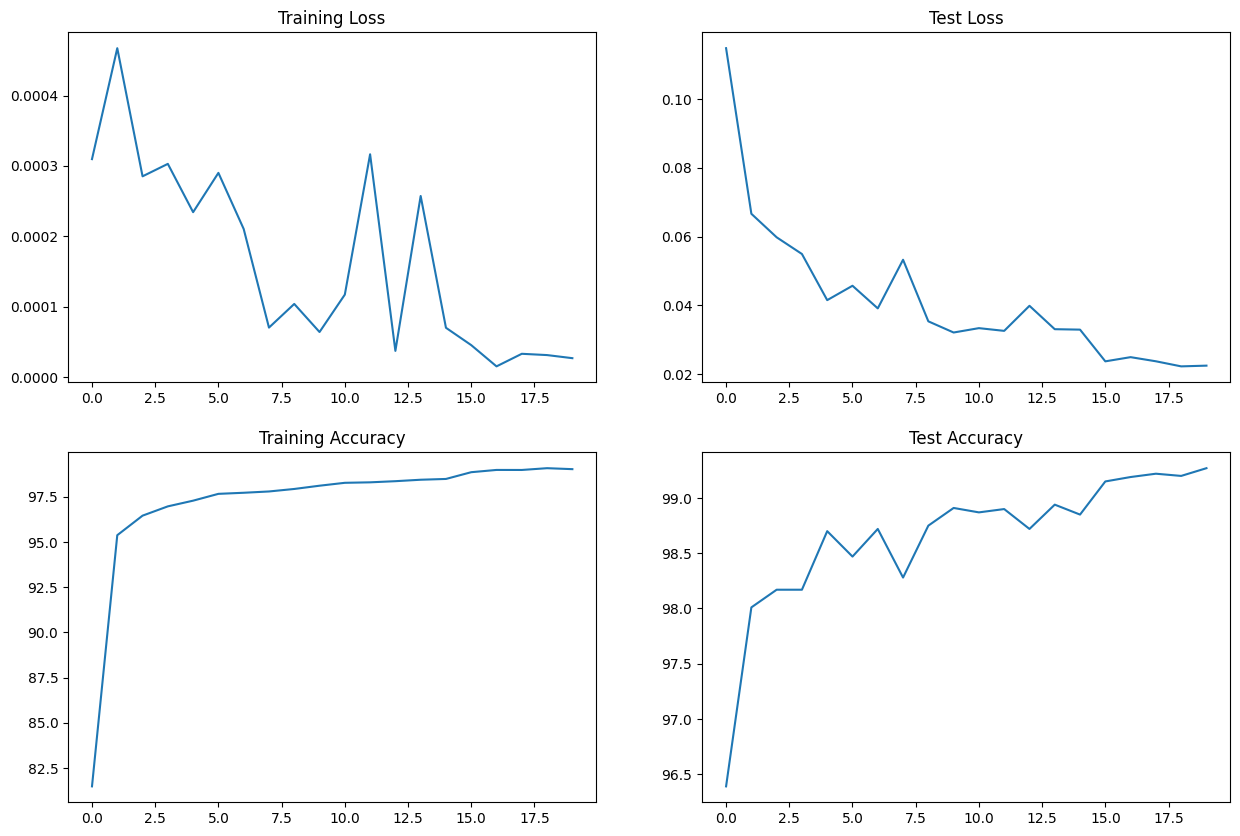

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([loss.cpu().item() for loss in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")